## Two-layer QG Model example to provide an understanding of how [pyqg](https://github.com/pyqg) works. 

### QG Model Parameters
**beta** : Gradient of coriolis parameter. Units: meters -1 seconds -1

**rd**   : Deformation radius. Units: meters.

**delta**: Layer thickness ratio (H1/H2)

**H1**   : Upper layer thickness. Units?

**U1**   : Upper layer flow. Units: m/s

**U2**   : Lower layer flow. Units: m/s

**tmax** : Total time of integration (units: model time)

**twrite** : Interval for cfl writeout (units: number of timesteps)

**tavestart** : Start time for averaging (units: model time)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyqg
import time

from matplotlib.animation import FFMpegWriter
from matplotlib import animation, rc
from IPython.display import HTML
plt.rcParams['animation.embed_limit'] = 2**128

## 1. Initialize and Run Model

The model will run for 10 years and start averaging after 5 years. 

INFO:  Logger initialized


m.q  (2, 64, 64) PV anomaly. First axis contains the layer numbers. In this case there are two.
m.Qy  (2,) background PV gradient
m.y  (64, 64)
m.x  (64, 64)
m.ph (2, 64, 33) spectral variable (complex)
m.p (2, 64, 64) stream function


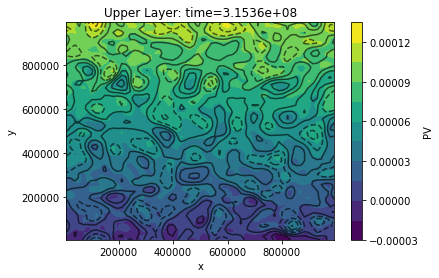

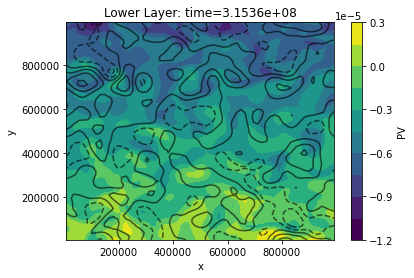

In [2]:
# These are essentially the model defaults in pyqg.QGModel
beta = 1.5e-11
rd = 15000.0
delta = 0.25
H1=500
U1=0.025
U2=0.0

year = 24*60*60*365.; tmax=10*year  # tmax is like seconds in 10 years
twrite= 24*60*60 # like daily writeouts #10000
tavestart= 5*year


m = pyqg.QGModel(beta=beta, rd=rd, delta=delta, H1=H1, U1=U1, U2=U2, tmax=tmax, twrite=twrite, tavestart=tavestart)
m.run() # Run the model forward without stopping until the end.

# Print the shape of some of the model outputs
print('m.q ', m.q.shape, 'PV anomaly. First axis contains the layer numbers. In this case there are two.')
print('m.Qy ', m.Qy.shape, 'background PV gradient') 
print('m.y ', m.y.shape)
print('m.x ', m.x.shape)
print('m.ph', m.ph.shape, 'spectral variable (complex)') 
print('m.p', m.p.shape, 'stream function') 


# PV Field
q_upper = m.q[0] + m.Qy[0]*m.y
q_lower = m.q[1] + m.Qy[1]*m.y


### Visualize PV field and stream functions from the two-layer QG Model

plt.figure()
plt.contourf(m.x, m.y, q_upper, 12, vmin=q_upper.min(), vmax=q_upper.max(), cmap='viridis'); plt.colorbar(label='PV'); 
plt.contour(m.x, m.y, m.p[0], colors='k', alpha=.6)
plt.xlabel('x'); plt.ylabel('y'); plt.title('Upper Layer: time=%g' % m.t)

plt.figure()
plt.contourf(m.x, m.y, q_lower, 12, vmin=q_lower.min(), vmax=q_lower.max(), cmap='viridis'); plt.colorbar(label='PV')
plt.contour(m.x, m.y, m.p[1], colors='k', alpha=.6)
plt.xlabel('x'); plt.ylabel('y'); plt.title('Lower Layer: time=%g' % m.t);



**Courant–Friedrichs–Lewy (CFL)**
- Courant–Friedrichs–Lewy: related to numerical stability. 

Why doesn't the stream function in the lower layer align with the PV field?

## 2. Look at some diagnostics

In [ ]:
m.describe_diagnostics()


## 3. Run with snapshots

In [ ]:
# functions for plotting and visualize the PV evolution

def plot_q(m):
    '''Plot PV anomaly field for the upper layer'''
    plt.figure()    
    plt.contourf(m.x, m.y, m.q[0], 12, vmin=m.q[0].min(), vmax=m.q[0].max(), cmap='RdBu_r'); plt.colorbar(label='PV Anomaly'); 
    plt.xlabel('x'); plt.ylabel('y'); plt.title('Upper Layer: time=%g' % m.t)
    plt.show()
    
def plot_Q(m):
    '''Plot the background PV field for the upper layer'''
    Q_upper = m.q[0] + m.Qy1*m.y
    plt.figure()    
    plt.contourf(m.x, m.y, Q_upper, 12, vmin=Q_upper.min(), vmax=Q_upper.max(), cmap='viridis'); plt.colorbar(label='PV'); 
    plt.xlabel('x'); plt.ylabel('y'); plt.title('Upper Layer: time=%g' % m.t)
    plt.show()
    
plot_q(m)
plot_Q(m)

In [ ]:
year = 24*60*60*360.
tavestart=5*year
twrite=1000

m = pyqg.QGModel(tmax=10*year, twrite=10000, tavestart=5*year)

q_snaps = xr.DataArray(data=m.q[:, np.newaxis,:,:],
                       dims=['z','time','x','y'],
                       coords={'z': [1,2], 'time': [m.t],'x': m.x[0,:] ,'y': m.y[:,0]})

for snapshot in m.run_with_snapshots(tsnapstart=tavestart, tsnapint=(tmax-tavestart)/40):
#     print(snapshot)
    
    q_int = xr.DataArray(data=m.q[:, np.newaxis,:,:],
                       dims=['z','time','x','y'],
                       coords={'z': [1,2], 'time': [m.t],'x': m.x[0,:] ,'y': m.y[:,0]})
    
    q_snaps = xr.concat([q_snaps, q_int], "time")

    
print(q_snaps.shape)
print(q_snaps.dims)
    

## 4. Create animation

In [ ]:
# Would be nice to use xmovie, however I can't install it! Incompatible Cartopy. Need to check environment conflicts.

# from xmovie import Movie
# mov = Movie(q_snaps)
# # mov.save('movie.gif')
# mov.preview(1)

In [ ]:
n = q_snaps.shape[1]

fig = plt.figure(figsize=(10,10))
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)

ax = plt.subplot(111)
q_snaps[0,0,:,:].plot.contourf(levels=np.arange(-3e-5, 3.5e-5, .5e-5), vmin=-3e-5, vmax=3e-5, extend='both', cmap='RdBu_r')
plt.xlabel('x', fontsize=22); plt.ylabel('y', fontsize=22); plt.title('Upper Layer: time=%g' % q_snaps[0,0,:,:].time.values, fontsize=22)
ax.set_aspect(1)

def animate(i): 
    ax.clear()
    cont = q_snaps[0,i,:,:].plot.contourf(levels=np.arange(-3e-5, 3.5e-5, .5e-5), vmin=-3e-5, vmax=3e-5, extend='both', cmap='RdBu_r', add_colorbar=False); 
    plt.xlabel('x', fontsize=22); plt.ylabel('y', fontsize=22); plt.title('Upper Layer: time=%g' % q_snaps[0,i,:,:].time.values, fontsize=22)
    ax.set_aspect(1)
    return cont 

anim = animation.FuncAnimation(fig, animate, interval=400, frames=n)


# anim.save('/Users/hillary/Documents/projects/lcs-ml/movies/QG_example.mp4')
# anim.save('basic_animation.mp4', fps=30)

HTML(anim.to_jshtml()) # Convert animation to JavaScript widget

## 5. Add Lagrangian particles 

For parts 5 and 6, I followed an example found [here](https://github.com/pyqg/pyqg/blob/master/examples/vis_particles.ipynb)

In [ ]:
# setup model
year = 24*60*60*360.
tavestart=5*year
tmax=10*year
twrite=1000000

m = pyqg.QGModel(tmax=tmax, twrite=twrite, nx=64, tavestart=tavestart)

#### Set up Lagrangian particles

In [ ]:
x0,y0 = np.meshgrid(m.x[0,::2], m.y[::2,0])
x0 = x0.ravel() # Return a contiguous flattened array
y0 = y0.ravel()
Npart = x0.size


### [pyqg.particles.GriddedLagrangianParticleArray2D](https://pyqg.readthedocs.io/en/latest/api.html#pyqg.GriddedLagrangianParticleArray2D)
**Parameters:**

**x0, y0** (array-like) – Two arrays (same size) representing the particle initial positions.

**Nx, Ny** (int) – Number of grid points in the x and y directions

**grid_type: {‘A’}** – Arakawa grid type specifying velocity positions.

**periodic_in_x** (bool) – Whether the domain wraps in the x direction.

**periodic_in_y** (bool) – Whether the domain ‘wraps’ in the y direction.

**xmin, xmax** (int) – Maximum and minimum values of x coordinate

**ymin, ymax** (int) – Maximum and minimum values of y coordinate

In [ ]:
# Lagrangian particles with velocities given on a regular cartesian grid. 
lpa = pyqg.particles.GriddedLagrangianParticleArray2D(x0, y0, m.nx, m.ny,
        periodic_in_x=True, periodic_in_y=True,
        xmin=0, xmax=m.L, ymin=0, ymax=m.W)


## 6. Advance particles using a gridded velocity field

### [step_forward_with_gridded_uv](https://pyqg.readthedocs.io/en/latest/api.html#step_forward_with_gridded_uv)

In [ ]:
# number of particles to save
Nhold = 40
particle_history = np.zeros((Nhold,2,Npart)) 


In [ ]:
# set up extended grid for lagrangian particles
x = np.hstack([m.x[0,0]-m.dx, m.x[0,::2], m.x[0,-1]+m.dx])
y = np.hstack([m.y[0,0]-m.dy, m.y[::2,0], m.y[-1,0]+m.dy])


In [ ]:
# hack to reset the timer
m.tmax = 10.01*year
if m.t > 10*year:
    m.t = 10*year
    

#### Run particles with snapshots

In [ ]:
# add stream function (pH?)
lpa_snaps = xr.Dataset({'q' : (['z','time','x','y'], m.q[:, np.newaxis,:,:]),
                           'u' : (['z','time','x','y'], m.u[:, np.newaxis,:,:]),
                           'v' : (['z','time','x','y'], m.v[:, np.newaxis,:,:]),
                           'particle_history' : (['Nhold','time','axis','Npart'], particle_history[:, np.newaxis,:,:])},
                           coords={'z': [1,2],
                                  'time': [m.t],
                                  'x': m.x[0,:],
                                  'y': m.y[:,0],
                                  'axis' : [1,2]})

n=0

for snapshot in m.run_with_snapshots(tsnapstart=tavestart, tsnapint=m.dt):# #tsnapstart=0, tsnapint=(tmax-tavestart)/10):
    
    # set up velocities for lagrangian advection (need a view with wrapped values)
    u = m.u[0][np.r_[-1,0:m.ny,0]][:,np.r_[-1,0:m.nx,0]]
    v = m.v[0][np.r_[-1,0:m.ny,0]][:,np.r_[-1,0:m.nx,0]]
    
    if n>=1:
        # Advance particles using a gridded velocity field. 
        # Because of the Runga-Kutta timestepping, we need two velocity fields at different times.
        lpa.step_forward_with_gridded_uv(uprev, vprev, u, v, m.dt)
        particle_history = np.roll(particle_history, 1, axis=0)
        particle_history[0,0,:] = lpa.x
        particle_history[0,1,:] = lpa.y
   
    uprev = u.copy()
    vprev = v.copy()
    
    
    lpa_int = xr.Dataset({'q' : (['z','time','x','y'], m.q[:, np.newaxis,:,:]),
                           'u' : (['z','time','x','y'], m.u[:, np.newaxis,:,:]),
                           'v' : (['z','time','x','y'], m.v[:, np.newaxis,:,:]),
                           'particle_history' : (['Nhold','time','axis','Npart'], particle_history[:, np.newaxis,:,:])},
                           coords={'z': [1,2],
                                  'time': [m.t],
                                  'x': m.x[0,:],
                                  'y': m.y[:,0],
                                  'axis' : [1,2]})
        
    lpa_snaps = xr.concat([lpa_snaps, lpa_int], "time")

    n+=1
    
    if n>500:
        break

## 7. Animate PV anomaly field with particles

In [ ]:
n = lpa_snaps.particle_history.shape[1]

fig = plt.figure(figsize=(10,10))
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)

ax = plt.subplot(111)
lpa_snaps.q[0,0,:,:].plot.contourf(levels=np.arange(-3e-5, 3.5e-5, .5e-5), vmin=-3e-5, vmax=3e-5, cmap='RdBu_r', extend='both', add_colorbar=True)
plt.plot(lpa_snaps.particle_history[0,history,0,:].values.ravel(),lpa_snaps.particle_history[0,history,1,:].values.ravel(), 'k.', ms=4) 
plt.xlim(x.min(), x.max()); plt.ylim(y.min(), y.max())
plt.xlabel('x'); plt.ylabel('y')
ax.set_aspect(1)

def animate(i): 
    
    
    xpos = lpa_snaps.particle_history[:,i,0,:]
    dxdt = np.gradient(xpos, axis=0)
    I = np.where((dxdt<=-10000) | (dxdt>=10000))
    xpos[I[0],I[1]] = np.nan

    ypos = lpa_snaps.particle_history[:,i,1,:]
    dydt = np.gradient(ypos, axis=0)
    J = np.where((dydt<=-10000) | (dydt>=10000))
    ypos[J[0],J[1]] = np.nan


    ax.clear()
    cont1 = lpa_snaps.q[0,i,:,:].plot.contourf(levels=np.arange(-3e-5, 3.5e-5, .5e-5), vmin=-3e-5, vmax=3e-5, cmap='RdBu_r', alpha=0.5, extend='both', add_colorbar=False)
    cont2 = plt.plot(lpa_snaps.particle_history[0,i,0,:].values.ravel(),lpa_snaps.particle_history[0,i,1,:].values.ravel(), 'k.', ms=4) 
    cont3 = plt.plot(xpos,ypos, linewidth=2) ;
    plt.xlim(x.min(), x.max()); plt.ylim(y.min(), y.max())
    plt.xlabel('x', fontsize=22); plt.ylabel('y', fontsize=22)
    ax.set_aspect(1)
    return cont1, cont2, cont3

anim = animation.FuncAnimation(fig, animate, interval=100, frames=n)
HTML(anim.to_jshtml()) # Convert animation to JavaScript widget


In [ ]:
# n = lpa_snaps.time.shape[0]

# fig = plt.figure(figsize=(10,10))
# plt.rc('xtick', labelsize=18) 
# plt.rc('ytick', labelsize=18)

# ax = plt.subplot(111)
# lpa_snaps.q[0,0,:,:].plot.contourf(levels=np.arange(-3e-5, 3.5e-5, .5e-5), vmin=-3e-5, vmax=3e-5, cmap='RdBu_r', extend='both', add_colorbar=True)
# plt.plot(lpa_snaps.particle_history[0,0,0,:].values.ravel(),lpa_snaps.particle_history[0,0,1,:].values.ravel(), 'k.', ms=4) 
# plt.xlim(x.min(), x.max()); plt.ylim(y.min(), y.max())
# plt.xlabel('x'); plt.ylabel('y')
# ax.set_aspect(1)

# def animate(i): 
#     ax.clear()
#     cont1 = lpa_snaps.q[0,i,:,:].plot.contourf(levels=np.arange(-3e-5, 3.5e-5, .5e-5), vmin=-3e-5, vmax=3e-5, cmap='RdBu_r', extend='both', add_colorbar=False)
#     cont2 = plt.plot(lpa_snaps.particle_history[0,i,0,:].values.ravel(),lpa_snaps.particle_history[0,i,1,:].values.ravel(), 'k.', ms=4) 
#     plt.xlim(x.min(), x.max()); plt.ylim(y.min(), y.max())
#     plt.xlabel('x', fontsize=22); plt.ylabel('y', fontsize=22)
#     ax.set_aspect(1)
#     return cont1, cont2

# anim = animation.FuncAnimation(fig, animate, interval=100, frames=n)
# HTML(anim.to_jshtml()) # Convert animation to JavaScript widget

## 8. Animate PV anomaly and velocity fields

In [ ]:
n = lpa_snaps.time.shape[0]

fig = plt.figure(figsize=(10,10))
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)

ax = plt.subplot(111)
plt.contourf(lpa_snaps.x, lpa_snaps.y, lpa_snaps.q[0,0,:,:], 12, cmap='RdBu_r', extend='both'); plt.colorbar(label='PV Anomaly'); 
plt.quiver(lpa_snaps.x, lpa_snaps.y, lpa_snaps.u[0,0,:,:], lpa_snaps.v[0,0,:,:], scale=10)
plt.xlabel('x'); plt.ylabel('y')
plt.xlim(x.min(), x.max()); plt.ylim(y.min(), y.max())
ax.set_aspect(1)

def animate(i): 
    ax.clear()
    cont1 = lpa_snaps.q[0,i,:,:].plot.contourf(levels=np.arange(-3e-5, 3.5e-5, .5e-5), vmin=-3e-5, vmax=3e-5, extend='both', cmap='RdBu_r', add_colorbar=False);
    cont2 = plt.quiver(lpa_snaps.x, lpa_snaps.y, lpa_snaps.u[0,i,:,:], lpa_snaps.v[0,i,:,:], scale=10)
    plt.xlabel('x', fontsize=22); plt.ylabel('y', fontsize=22)
    plt.xlim(x.min(), x.max()); plt.ylim(y.min(), y.max())
    ax.set_aspect(1)
    return cont1, cont2

anim = animation.FuncAnimation(fig, animate, interval=100, frames=n)
HTML(anim.to_jshtml()) # Convert animation to JavaScript widget
